In [27]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import h5py

## Hyper Params


In [40]:
leave_x_out = 1             # how many echoes to leave out for testing
echo_train_length = 25      # the number of echoes in each echo train
tmpdir = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp')
print(tmpdir)   

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp


# Loading data


In [ ]:
# Data definition

pat3 = {
    "h5_path": Path("/scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5"),
    "pat_id": "0003_umcg_pst_ksps",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}
pat4 = {
    "h5_path": "/scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5",
    "pat_id": "0004_ANON9616598",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}

In [30]:
# shape of the data: (averages, slices, coils, rows, columns)

def load_patient_data(patient_dict: dict, debug=False) -> dict:
    """
    Loads the k-space and reconstruction data for a given patient from the h5 file.
    
    Args:
    - patient_dict (dict): Dictionary containing the necessary paths and indices for the patient.
    
    Returns:
    - patient_dict (dict): The updated dictionary containing loaded data.
    """
    with h5py.File(patient_dict["h5_path"], 'r') as f:
        print(f"\nLoaded data for {patient_dict['h5_path']}")

        patient_dict["kspace"] = f['kspace'][:]
        patient_dict["slice_ksp"] = patient_dict["kspace"][patient_dict["avg_idx"], 
                                                          patient_dict["slice_idx"], 
                                                          patient_dict["coil_idx"], ...]
        print(f"Slice ksp shape: {patient_dict['slice_ksp'].shape}")
        
        # Optional: Convert to image space (inverse FFT)
        patient_dict["slice_img"] = np.fft.ifft2(patient_dict["slice_ksp"])
        
        if debug:
            for key in f.keys():
                print(key)
            for attr in f.attrs:
                print(attr, f.attrs[attr])

        # Debug: Print the shape and dtype of the k-space data
        print(f"\nkspace Shape: {patient_dict['kspace'].shape}")
        print(f"kspace dtpe: {patient_dict['kspace'].dtype}")
        
    return patient_dict

In [31]:
# Load data for both patients
pat3 = load_patient_data(pat3, debug=True)
pat4 = load_patient_data(pat4, debug=True)


Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Slice ksp shape: (768, 651)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 384 307   0]
acquisition AXT2
cols_dcm_hdr 768
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_steps_dcm_hdr 651
norm 0.12
pat_pos_dcm_hdr HFS
patient_id ANON5046358
patient_id_seq 0003
percent_phase_fov_dcm_hdr 100.0
percent_sampling_dcm_hdr 80.0
pixel_spacing_dcm_hdr [0.234375 0.234375]
rows_dcm_hdr 768

kspace Shape: (3, 30, 20, 768, 651)
kspace dtpe: complex64

Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5
Slice ksp shape: (640, 551)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 320 256   0]
acquisition AXT2
cols_dcm_hdr 640
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_step

## check for zero-padding

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/003_umcg_pst_kspskspace.png
Saved kspace image to /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/003_umcg_pst_kspskspace.png


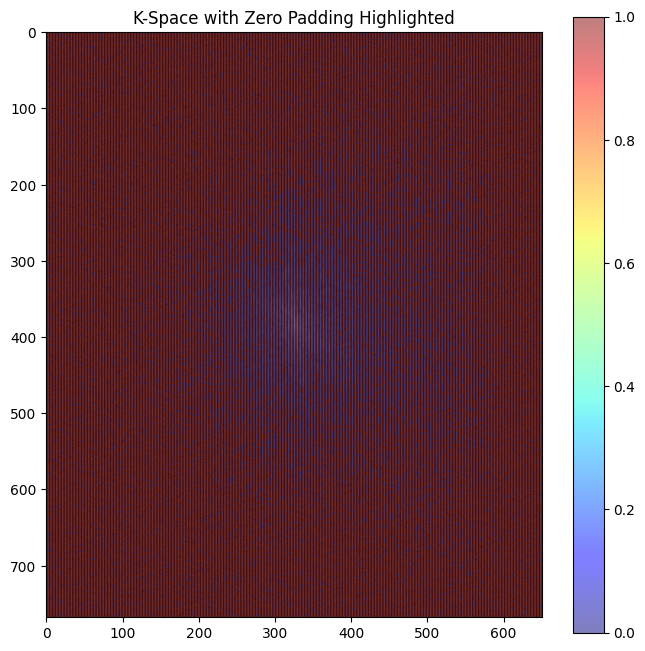

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/0004_ANON9616598kspace.png
Saved kspace image to /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/0004_ANON9616598kspace.png


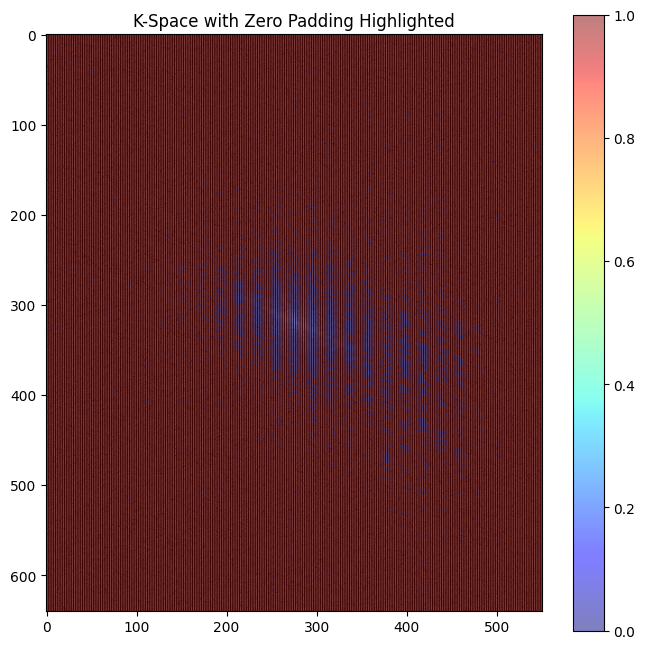

In [41]:
def check_zero_padding(kspace: np.ndarray, threshold: float = 1e-5) -> np.ndarray:
    """
    This function checks for zero-padding in the k-space data.
    It returns a boolean array indicating where zero-padding is present (near-zero values).
    
    Args:
    kspace (np.ndarray): The k-space data array.
    threshold (float): The threshold below which values are considered zero-padding.

    Returns:
    np.ndarray: A boolean array where True indicates zero-padding, False otherwise.
    """
    assert len(kspace.shape) == 2, "Input k-space should be a 2D array (slice)"

    # Identify where the k-space values are below the threshold (indicating zero-padding)
    zero_padding_mask = np.abs(kspace) < threshold
    return zero_padding_mask


def plot_zero_padding(patient_dict: dict, threshold: float = 1e-5, epsilon: float = 1e-8):
    """
    This function visualizes the k-space slice and highlights zero-padded regions.
    
    Args:
    patient_dict (dict): The dictionary containing the patient
    threshold (float): The threshold below which values are considered zero-padding.
    epsilon (float): A small value added to avoid log(0) issues.
    """

    ksp_slice = patient_dict["slice_ksp"]

    assert len(ksp_slice.shape) == 2, "Input k-space should be a 2D array (slice)"

    # Identify zero padding and highlight it
    zero_padding_mask = check_zero_padding(ksp_slice, threshold)
    
    # Avoid log(0) by adding epsilon
    ksp_log = np.log(np.abs(ksp_slice) + epsilon)

    # Plot the k-space with a mask overlay to show zero-padded areas
    plt.figure(figsize=(8, 8))
    plt.imshow(ksp_log, cmap='gray')
    plt.imshow(zero_padding_mask, cmap='jet', alpha=0.5)  # Overlay zero-padding mask
    plt.colorbar()
    plt.title('K-Space with Zero Padding Highlighted')

    # Save the grayscale image with log(k-space) values
    fname = tmpdir / f"{patient_dict['pat_id']}kspace.png"
    print(fname)
    plt.imsave(str(fname), ksp_log, cmap='gray')
    print(f"Saved kspace image to {fname}")
    
    plt.show()


plot_zero_padding(pat3)
plot_zero_padding(pat4)

# Visualization Functions


In [ ]:
def plot_kspace(kspace: np.ndarray) -> None:
    plt.figure()
    # The techinical explanation is: kspace is a complex number, and the log of a complex number is a complex number, so we take the absolute value of the complex number to get a real number, and then we take the log of that real number.
    plt.imshow(np.log(np.abs(kspace[0, 0, 0, ...])), cmap='gray')
    plt.colorbar()
    plt.show()

In [ ]:
plot_kspace(data)